In [178]:

import numpy as np
import random, math 
from scipy.optimize import minimize
import matplotlib.pyplot as plt



def linear_kernel(xi,xj):
    return(np.dot(xi,xj))

def poli_kernel(xi,xj,p):
    return (np.dot(xi,xj)+1)**p

def RBF_kernel(xi,xj,sigma):
    norm = np.linalg.norm(xi-xj)
    return np.exp(-norm**2/(2*sigma**2))

def compute_matrix_P(x,t,n_kernel_args,kernel,*args):
    '''
    x - array Nxn with inputs 
    t - array Nx1 with target values   
    kernel - kernel function
    
    '''

    t_A = np.dot(t,np.transpose(t))

    if n_kernel_args == 0: 
        K_matrix = [kernel(i, j) for i in x for j in x]
    else:     
        K_matrix = [kernel(i, j,*args) for i in x for j in x]

    n = len(x)
    K_matrix = np.array(K_matrix).reshape(n,n)

    P =  np.multiply(t_A, K_matrix)
    
    return P

def objective(alpha):
    '''
    alpha - Nx1 array
    P - NxN matrix (global variable)

    output - scalar
    '''
    N = len(P)
    alpha = alpha.reshape(N,1)
    alpha_m = np.dot(alpha,np.transpose(alpha))
    
    return ((np.sum(np.multiply(alpha_m,P))/2 - np.sum(alpha)))

def zerofun(alpha):
    '''
    alpha - Nx1 array
    targets -  Nx1 array with target values   
    
    output - scalar
    '''
    N = len(targets)
    alpha = alpha.reshape(N,1)
    return np.ndarray.item(np.dot(np.transpose(alpha), targets))

def get_b(suport_vectors,n_kernel_args,kernel,*args):
    '''
    suport_vectors[i][0] = inputs
    suport_vectors[i][1] = targets
    suport_vectors[i][2] = alpha
    
    
    '''
    b = 0
    s = suport_vectors[0][0] #s could be any point of the margin in the suport vector 
    t = suport_vectors[0][1]

    if n_kernel_args == 0:
        
        for i in range(len(suport_vectors)):
            b = b + suport_vectors[i][1]*suport_vectors[i][2]*kernel(s,suport_vectors[i][0])
    else:
        for i in range(len(suport_vectors)):
            b = b + suport_vectors[i][1]*suport_vectors[i][2]*kernel(s,suport_vectors[i][0],*args)

    return np.ndarray.item(b - t)

def indicator(point,suport_vectors,b,n_kernel_args,kernel,*args):
    '''
    point - 1xn sample to be evaluated
    suport_vectors[i][0] = inputs
    suport_vectors[i][1] = targets
    suport_vectors[i][2] = alpha
    '''
    
    ind = 0 

    if n_kernel_args == 0:
        for i in range(len(suport_vectors)):
            ind = ind + suport_vectors[i][1]*suport_vectors[i][2]*kernel(suport_vectors[i][0],point)
    else:
        for i in range(len(suport_vectors)):
            ind = ind + suport_vectors[i][1]*suport_vectors[i][2]*kernel(suport_vectors[i][0],point,*args)

            
    return np.ndarray.item((ind - b ))

def svm_classifier(indicator):
    return np.sign(indicator)

In [179]:
#Data creation
classA = np.concatenate((np.random.randn(10,2)*0.2+[1.5,0.5],np.random.randn(10,2)*0.2+[-1.5,0.5]))
classB = np.random.randn(20,2)*0.2+[0.0,-0.5]
inputs = np.concatenate((classA,classB))
targets = np.concatenate((np.ones(classA.shape[0]),-np.ones(classB.shape[0])))
N = inputs.shape[0]#Numberofrows(samples)
permute = list(range(N))
random.shuffle(permute)
inputs = inputs[permute,:]
targets = targets[permute]

In [180]:
#                               Parameters                                 #
C = 1       #set C as a large number to not use slack variables       #
kernel = linear_kernel                                                     #
n_kernel_args = 0 #used to diferentiate kernels that need extra arguments  #
kernel_args = 0                                                            # 
############################################################################


targets = targets.reshape(N,1)
P = compute_matrix_P(inputs,targets,n_kernel_args,kernel,kernel_args)
alpha0 = np.zeros(N)
B = [(0,C) for b in range(N)]
XC = {'type':'eq', 'fun': zerofun}
ret = minimize(objective, alpha0, bounds=B, constraints=XC)
alpha = ret.x.round(5)
suport_vectors = [(inputs[i],targets[i],alpha[i]) for i,_ in enumerate(alpha) if alpha[i]!=0]# and alpha[i]<C]
b = get_b(suport_vectors,n_kernel_args,kernel,kernel_args)



In [181]:
# evaluation using the own dataset. Correct value should be N
yhat = []
for x in inputs:
    yhat.append(svm_classifier(indicator(x,suport_vectors,b,n_kernel_args,kernel,kernel_args)))

yhat =np.array(yhat).reshape(targets.shape)

(yhat == targets).sum()

40

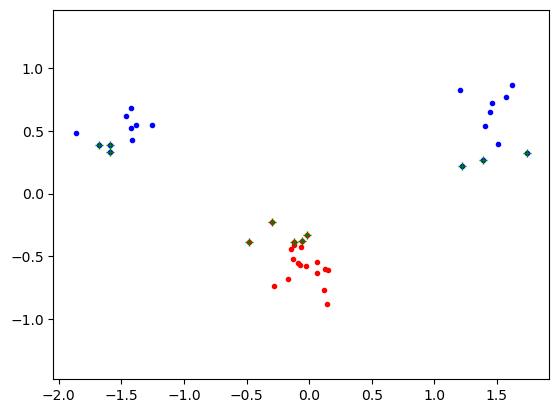

In [182]:
plt.plot([p[0]for p in classA],[p[1]for p in classA],'b.')
plt.plot([p[0]for p in classB],[p[1]for p in classB],'r.')
plt.plot([p[0][0]for p in suport_vectors],[p[0][1]for p in suport_vectors],'g+')
plt.axis('equal')#Force same scale on both axes
plt.savefig('svmplot.pdf')#Save a copy in a file
plt.show()#Show the plot on the screen


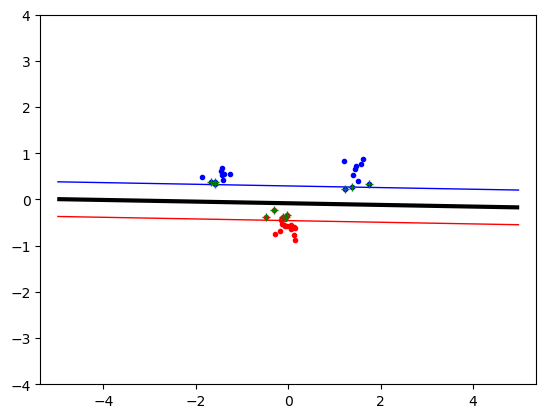

In [183]:
plt.plot([p[0]for p in classA],[p[1]for p in classA],'b.')
plt.plot([p[0]for p in classB],[p[1]for p in classB],'r.')
plt.plot([p[0][0]for p in suport_vectors],[p[0][1]for p in suport_vectors],'g+')

xgrid=np.linspace(-5,5)
ygrid=np.linspace(-4,4)
grid=np.array([[indicator([x,y],suport_vectors,b,n_kernel_args,kernel,kernel_args) for x in xgrid] for y in ygrid])
plt.contour(xgrid,ygrid,grid,(-1.0,0.0,1.0), colors=('red','black','blue'), linewidths=(1,3,1))

plt.axis('equal')#Force same scale on both axes

plt.savefig('svmboundary.pdf')#Save a copy in a file
plt.show()#Show the plot on the screen
